In [113]:
# Entrenamiento Latitudes y Longitudes
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

#Modelo Tensor
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.regularizers import l2


In [114]:
# Cargamos el Dataset
file_path = "dataset/dataset.csv"
df = pd.read_csv(file_path)

In [115]:
#Listamos columnas para X y con drop separamos como un filter
X_columns = [
    'latitude_pos_tx', 'longitude_pos_tx', 'elevation_pos_tx', 'fc', 'elevation', 
    'azimuth', 'year', 'mmdd', 'UTI', 'hour', 'delay', 'terrestrial_range', 
    'slant_range', 'final_latitude', 'final_longitude', 'final_elevation'
]
X = df[X_columns]
Y = df.drop(columns=X_columns)
#Parametros del dataset que no corresponden al X de entrenamiento.
X = X.drop(columns=['final_latitude','final_longitude','final_elevation'])

# Como solo vamos a observar las latitudes y longitudes, quitamos las alturas.
lat_columns = [f'lat_{i}' for i in range(1,101)]
long_columns = [f'long_{i}' for i in range(1,101)]
heights_columns = [f'elev_{i}' for i in range(1,101)]

Y = Y.drop(columns = heights_columns)
# Otras columnas que no tendré en cuenta para la predicción son 
# "delay", "terrestrial_range", "slant_range", por lo que las quito
unwanted_columns = ["delay","terrestrial_range","slant_range"]
X = X.drop(columns=unwanted_columns)


In [116]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state = 42)


In [117]:
# Normalizamos la Frecuencia de los X 
k_norm = 1E6
x_train["fc"] = x_train["fc"]/k_norm
x_test["fc"] = x_test["fc"]/k_norm
#decidimos tomar todas las decimas.
x_test.head()

,latitude_pos_tx,longitude_pos_tx,elevation_pos_tx,fc,elevation,azimuth,year,mmdd,UTI,hour
5104,-42.28,-63.4,0,30.0,30,91,2010.0,1215,0,12
2186,-42.28,-63.4,0,10.0,5,98,2010.0,1231,0,8
4371,-42.28,-63.4,0,23.0,32,88,2010.0,1215,0,12
831,-42.28,-63.4,0,10.0,5,98,2010.0,519,0,12
1421,-42.28,-63.4,0,10.0,5,98,2010.0,825,0,20


In [118]:
from tensorflow.keras import backend as K

def custom_mse(y_true,y_pred):
  return K.mean(K.square(y_pred-y_true), axis = -1)

In [119]:
# Sección si es necesario Normalizar o no, las latitudes y longitudes

# Modelo Red Neuronal capas
l2_reg = 0.003

inputs = Input(shape =(10,))
encoded = Dense(8, activation = 'relu',kernel_regularizer=l2(l2_reg))(inputs)
encoded = Dense(16, activation = "relu",kernel_regularizer=l2(l2_reg))(encoded)
encoded = Dense(32, activation = "relu",kernel_regularizer=l2(l2_reg))(encoded)
encoded = Dense(64, activation = "relu",kernel_regularizer=l2(l2_reg))(encoded)
encoded = Dense(128, activation = "relu",kernel_regularizer=l2(l2_reg))(encoded)
decoded = Dense(200, activation = 'linear',kernel_regularizer=l2(l2_reg))(encoded)

autoencoder = Model(inputs,decoded)
autoencoder.compile(optimizer = 'adamW', loss='mse',metrics = [custom_mse])
autoencoder.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 8)              │            88 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 200)            │        25,800 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,008 (144.56 KB)

 Trainable params: 37,008 (144.56 KB)

 Non-trainable params: 0 (0.00 B)

In [120]:
# Entrenamiento
history = autoencoder.fit(x_train,y_train, epochs=150, batch_size = 80
                          )
#validation_data = (x_test,y_test)

Epoch 1/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - custom_mse: 1271.0715 - loss: 1271.9664
Epoch 2/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - custom_mse: 23.9904 - loss: 24.6805
Epoch 3/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - custom_mse: 20.0072 - loss: 20.6130
Epoch 4/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - custom_mse: 18.9775 - loss: 19.5477
Epoch 5/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - custom_mse: 18.2041 - loss: 18.7591
Epoch 6/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - custom_mse: 17.6947 - loss: 18.2425
Epoch 7/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - custom_mse: 16.6251 - loss: 17.1687
Epoch 8/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - custom_mse: 16.1269 - loss: 16.6686
Epoch 9/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - custom_mse: 15.0791 - loss: 15.6201
Epoch 10/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - custom_mse: 13.3400 - loss: 13.8815
Epoch 11/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - custom_mse: 11.0335 - loss: 11.5770
Epoch 12/150


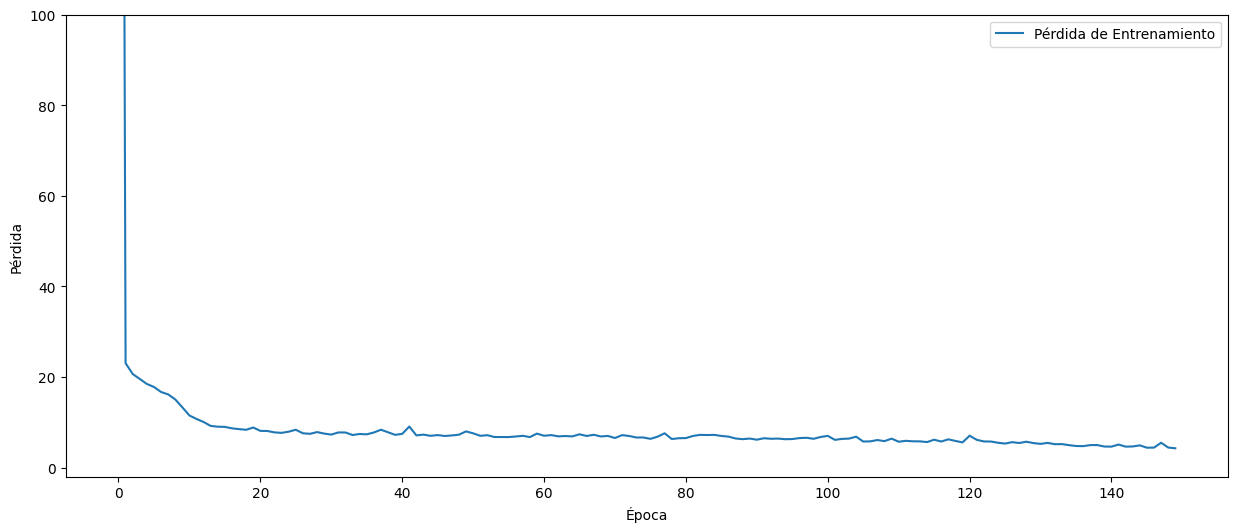

In [121]:
# Función de Pérdida durante el entrenamiento
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label = 'Pérdida de Entrenamiento')
#plt.plot(history.history['val_loss'], label = 'Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.ylim(-2,100)
plt.legend()
plt.show()

In [122]:
loss, custom_mse_value = autoencoder.evaluate(x_test, y_test)
print(f"Test Loss: {loss}")
print(f"Custom MSE on Test Set: {custom_mse_value}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - custom_mse: 3.7357 - loss: 4.2023
Test Loss: 4.241288185119629
Custom MSE on Test Set: 3.7746169567108154


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


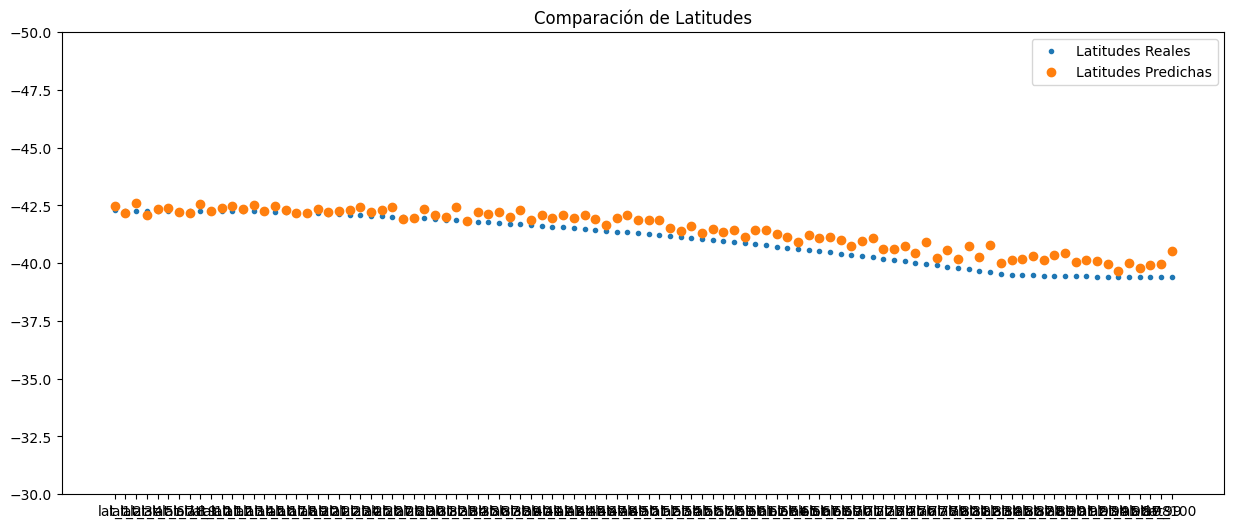

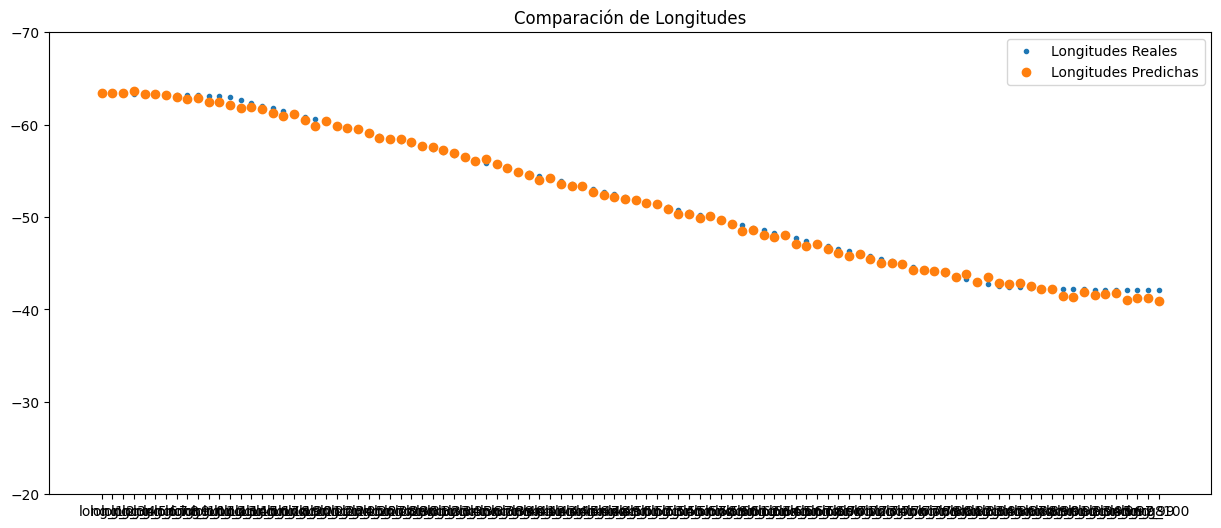

In [146]:
# Predecimos una muestra en particular de mi df
idx = 57

y_pred = autoencoder.predict(np.expand_dims(x_test.iloc[idx], axis = 0))

y_true =y_test.iloc[idx]
# Separamos Latitudes Longitudes
y_true_latitudes = y_true[0:100]
y_true_longitudes = y_true[100:200]

y_pred_latitudes = y_pred[0,0:100]
y_pred_longitudes = y_pred[0,100:200]

# Grafica Latitudes 
plt.figure(figsize = (15,6))
plt.plot(y_true_latitudes, label = 'Latitudes Reales', linestyle = 'None', marker = '.')
plt.plot(y_pred_latitudes, label = 'Latitudes Predichas', linestyle = 'None', marker = 'o')
plt.ylim(-30,-50)
plt.title('Comparación de Latitudes')
plt.legend()
plt.show()

# Graf. Longitudes
plt.figure(figsize=(15,6))
plt.plot(y_true_longitudes,label= 'Longitudes Reales', linestyle = 'None',marker= '.')
plt.plot(y_pred_longitudes,label= 'Longitudes Predichas', linestyle = 'None', marker = 'o')
plt.ylim(-20,-70)
plt.title("Comparación de Longitudes")
plt.legend()
plt.show()

In [143]:
mse_latitudes = custom_mse(y_true_latitudes,y_pred_latitudes)
print("Error cuadratico Medio Latitudes: ",mse_latitudes)
mse_longitudes = custom_mse (y_true_longitudes, y_pred_longitudes)
print("Error Cuadratico Medio Longitudes: ",mse_longitudes)

Error cuadratico Medio Latitudes:  tf.Tensor(0.7589395152815781, shape=(), dtype=float64)
Error Cuadratico Medio Longitudes:  tf.Tensor(17.844774098571037, shape=(), dtype=float64)


In [ ]:
save_model = False

if save_model == True:
  autoencoder.save('modelos_entrenamiento/fit_lat_lon1.h5')

In [ ]:
zzz